# 1.0 DATA PREPARATION

In [146]:
import pandas as pd
import numpy as np
import plotnine as pn
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [147]:
pn.options.dpi = 300

In [148]:
cdnow_raw_df = pd.read_csv('../data/cdnow.csv', index_col=0)

In [149]:
cdnow_raw_df.head(3)

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00


In [150]:
cdnow_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  object 
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.7+ MB


In [151]:
# convert to datetime
cdnow_df = (
    cdnow_raw_df
    .assign(date=lambda x: pd.to_datetime(x['date']))
)

In [152]:
cdnow_df['date'].dtype

dtype('<M8[ns]')

# 2.0 COHORT ANALYSIS

In [153]:
# Extract just the date part without time
min_date = cdnow_df['date'].min().date()
max_date = cdnow_df['date'].max().date()

# Print the range of dates
print(f"Data ranges from {min_date} to {max_date}")

Data ranges from 1997-01-01 to 1998-06-30


## Get Range of Initial Purchases

In [154]:
cdnow_first_purchase_tbl = (
    cdnow_df
    .sort_values(['customer_id','date'])
    .groupby('customer_id')
    .first()
                            )

In [155]:
cdnow_first_purchase_tbl.head()

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33


In [156]:
# Extract just the date part without time
min_date = cdnow_first_purchase_tbl['date'].min().date()
max_date = cdnow_first_purchase_tbl['date'].max().date()

# Print the range of dates
print(f"Dates range of initial purchases from {min_date} to {max_date}")

Dates range of initial purchases from 1997-01-01 to 1997-03-25


Despite containing a year and a half of data, all customers were acquired between 1/1997 and 3/1997.

## Visualize: All purchases within cohort

<Axes: xlabel='date'>

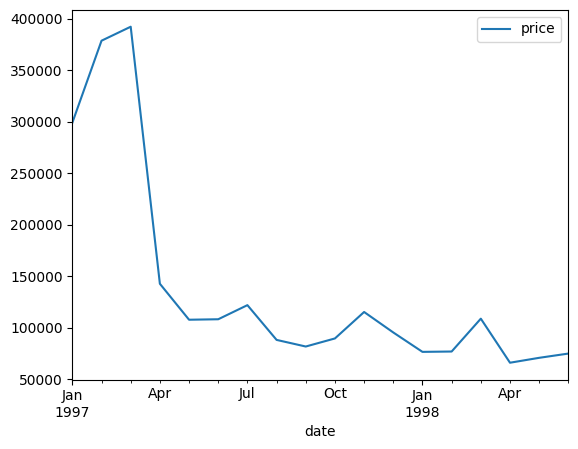

In [157]:
cdnow_df.reset_index() \
    .set_index('date') \
    [['price']] \
    .resample(rule='MS') \
    .sum() \
    .plot()

## Visualize: Individual Customer Purchases

In [158]:
# Select a subset of customer IDs
ids = cdnow_df['customer_id'].unique()
ids_selected = ids[:12]

/tmp/ipykernel_135805/2476615928.py:26: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observ

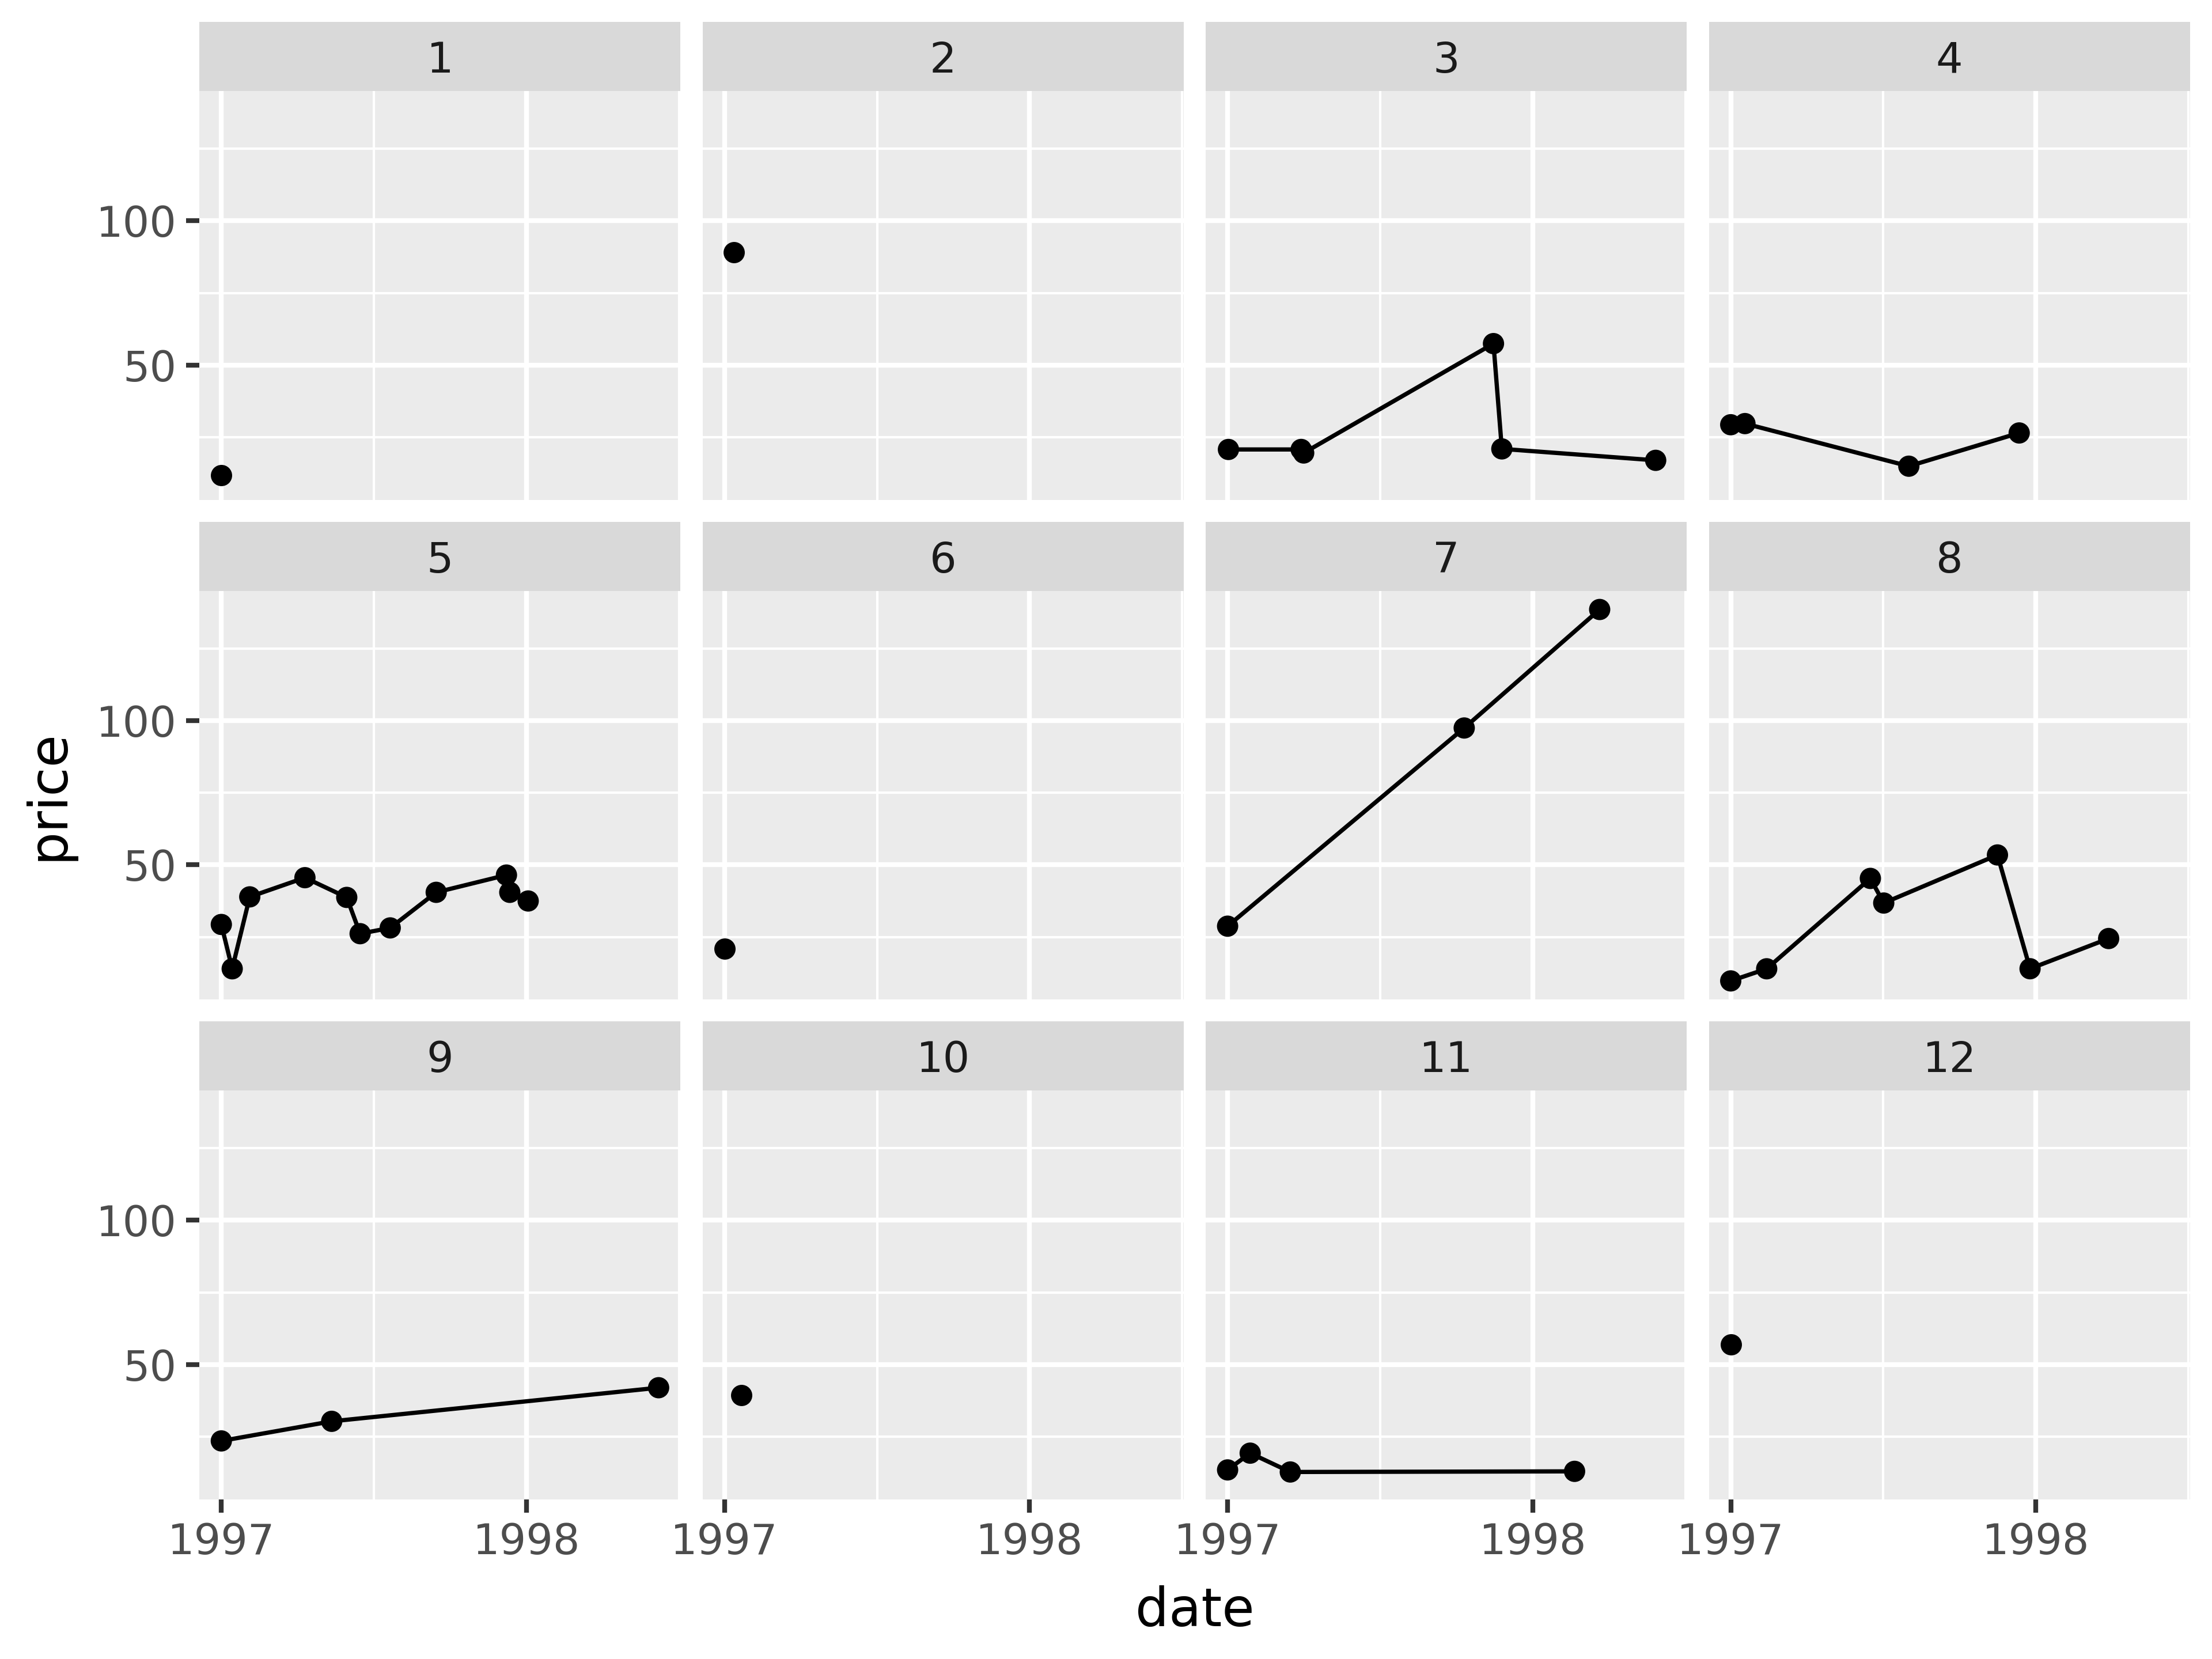

In [159]:
# ggplot API
# Filter the DataFrame for the selected customer IDs
cdnow_cust_id_subset_df = (
    cdnow_df[cdnow_df['customer_id'].isin(ids_selected)]
    .groupby(['customer_id', 'date'])
    .sum()
    .reset_index()
)

# Create the plot
plot = (
    pn.ggplot(
        cdnow_cust_id_subset_df,
        pn.aes('date', 'price', group='customer_id')
    )
    + pn.geom_line()
    + pn.geom_point()
    + pn.facet_wrap('~customer_id')
    + pn.scale_x_date(
        date_breaks='1 year',
        date_labels='%Y'
    )
)

# Display the plot
print(plot)

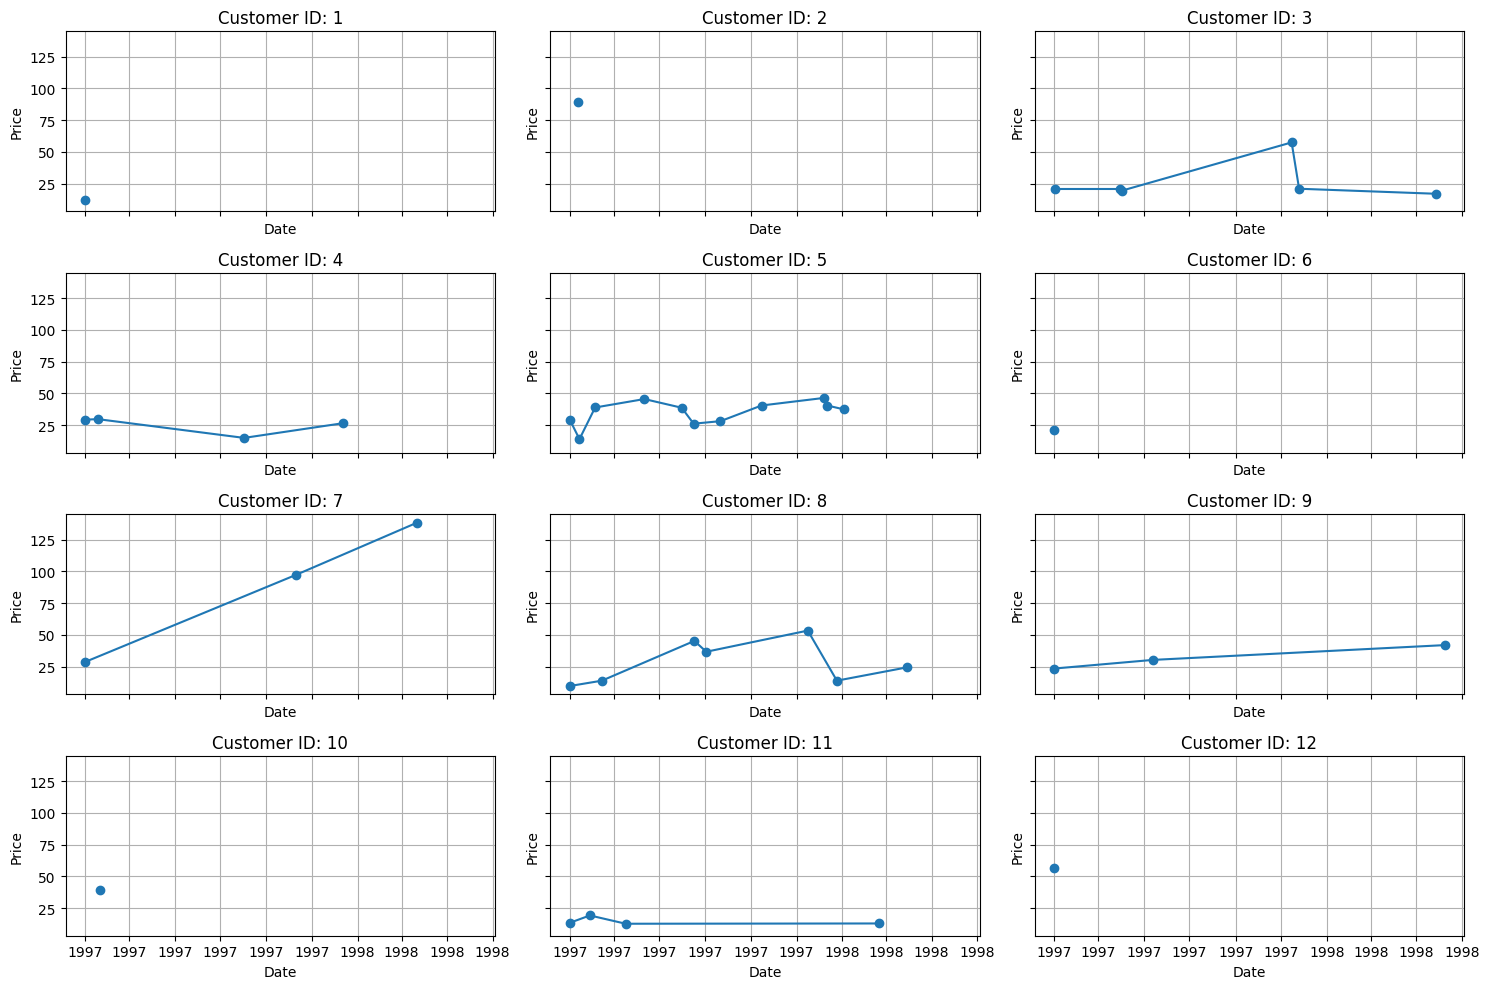

In [160]:
# Number of unique customers in the subset
unique_customers = cdnow_cust_id_subset_df['customer_id'].nunique()

# Define the number of rows and columns for the subplots
num_cols = 3
num_rows = (unique_customers + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for ax, (customer_id, group) in zip(axes, cdnow_cust_id_subset_df.groupby('customer_id')):
    ax.plot(group['date'], group['price'], marker='o', linestyle='-')
    ax.set_title(f'Customer ID: {customer_id}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
    ax.grid(True) 

# Remove any empty subplots
for i in range(unique_customers, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



# 3.0 FEATURE ENGINEERING

Frame problem:

- What will the customers spend in the next 90-days? (Regression)
- What is the probability of a customer to make a purchase in the next 90-days? (Classification)

## 3.1 TIME SPLITTING

In [161]:
n_days = 90
max_date = cdnow_df['date'].max()

# Calculate the cutoff date (90 days before end of data)
cutoff = max_date - pd.to_timedelta(n_days, unit='d')

In [162]:
temporal_in_df = cdnow_df[cdnow_df['date'] <= cutoff]
temporal_out_df = cdnow_df[cdnow_df['date'] > cutoff]

In [163]:
# Extract the minimum and maximum dates
min_date = temporal_in_df['date'].min().date()
max_date = temporal_in_df['date'].max().date()

# Print the range of dates
print(f"Dates range of temporal_in_df from {min_date} to {max_date}")

Dates range of temporal_in_df from 1997-01-01 to 1998-04-01


In [164]:
# Extract the minimum and maximum dates
min_date = temporal_out_df['date'].min().date()
max_date = temporal_out_df['date'].max().date()

# Print the range of dates
print(f"Dates range of temporal_out_df from {min_date} to {max_date}")

Dates range of temporal_out_df from 1998-04-02 to 1998-06-30


## 3.2 FEATURE ENGINEERING (RFM)

### Make Targets From Data

In [165]:
# flag for all data in the last 90 days
targets_df = (
    temporal_out_df
    .drop(['quantity','date'], axis=1) # must drop date to .sum()
    .groupby('customer_id')
    .sum()
    .rename({'price': 'spend_90_total'}, axis=1)
    .assign(spend_90_flag=1)  # Add a new column 'spend_90_flag' with value 1
)

In [166]:
targets_df.head(3)

,spend_90_total,spend_90_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1


In [167]:
# From almost 70k down to 3301
targets_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3301 entries, 3 to 23561
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   spend_90_total  3301 non-null   float64
 1   spend_90_flag   3301 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 77.4 KB


### Make Recency (Date) Features From 'in' Data

In [168]:
max_date = temporal_in_df['date'].max()

In [169]:
# show the date diff from the last date
recency_features_df = (
    temporal_in_df
    #.drop(['quantity','price'], axis=1) <- not necessary
    [['customer_id','date']]
    .groupby('customer_id')
    .apply(lambda x: (x['date'].max() - max_date).days, include_groups=False)
    .to_frame(name='recency') # <- changes customer_id column to become index
    .set_axis(['recency'], axis=1)
)

In [170]:
recency_features_df.head(3)

,recency
customer_id,
1,-455
2,-444
3,-127


In [171]:
recency_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   recency  23570 non-null  int64
dtypes: int64(1)
memory usage: 368.3 KB


### Make Frequency (Count) Features From 'in' Data

In [172]:
# how frequent customers are making purchases
frequency_features_df = (
    temporal_in_df[['customer_id','date']]
    .groupby('customer_id')
    .count()
    .set_axis(['frequency'], axis=1)
)

In [173]:
frequency_features_df.head()

,frequency
customer_id,
1,1
2,2
3,5
4,4
5,11


In [174]:
frequency_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   frequency  23570 non-null  int64
dtypes: int64(1)
memory usage: 368.3 KB


### Make Price (Monetary) Features From 'in' Data

In [175]:
# Add total and average spend
price_features_df = (
    temporal_in_df
    .groupby('customer_id')
    .aggregate({'price':['sum','mean']})
    .set_axis(['price_sum','price_mean'], axis=1)
)

In [176]:
price_features_df.head(3)

,price_sum,price_mean
customer_id,,
1,11.77,11.770
2,89.00,44.500
3,139.47,27.894


In [177]:
price_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price_sum   23570 non-null  float64
 1   price_mean  23570 non-null  float64
dtypes: float64(2)
memory usage: 552.4 KB


### 3.3 Combine Features

In [178]:
features_df = (
    pd.concat(
        [recency_features_df,frequency_features_df,price_features_df],axis=1
    )
    .merge(
        targets_df,
        left_index=True,
        right_index=True,
        how='left'
    )
    .fillna(0) # Customers that did not make a purchase show as NaN
)

In [179]:
features_df.head(3)

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
1,-455,1,11.77,11.770,0.00,0.0
2,-444,2,89.00,44.500,0.00,0.0
3,-127,5,139.47,27.894,16.99,1.0


In [180]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         23570 non-null  int64  
 1   frequency       23570 non-null  int64  
 2   price_sum       23570 non-null  float64
 3   price_mean      23570 non-null  float64
 4   spend_90_total  23570 non-null  float64
 5   spend_90_flag   23570 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 1.3 MB


In [181]:
features_df.spend_90_flag.value_counts()

spend_90_flag
0.0    20269
1.0     3301
Name: count, dtype: int64

The 90 flag class is highly imbalanced.

In [182]:
features_df.to_pickle('../artifacts/features_df.pkl')

# 4.0 MACHINE LEARNING

## Imports

## 4.1 Next 90-Day Spend Prediction (Regression)

In [ ]:
# import cudf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, roc_auc_score
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from catboost import CatBoostRegressor, CatBoostClassifier
import joblib

In [ ]:
# !nvidia-smi

In [59]:
# Data prep
features_df = pd.read_pickle('../artifacts/features_df.pkl')
# features_df = cudf.DataFrame.from_pandas(pandas_df)
y_reg = features_df['spend_90_total']
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]
# params
cv = 10
n_jobs = -1
random_seed=42

In [41]:
# Define the XGBRegressor with hyperparameters
xgb_reg_spec = XGBRegressor(
    objective='reg:squarederror',
        random_state=random_seed
    # tree_method='hist', # gpu_hist depreciated
    # device='cuda', # now use this
    # gpu_id=0
)

xgb_reg_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'alpha': [0, 0.1, 0.5, 1],  # L1 regularization term on weights
    'lambda': [1, 1.5, 2, 3]   # L2 regularization term on weights
}

# Grid search for XGBRegressor
xgb_reg_grid_search = GridSearchCV(
    estimator=xgb_reg_spec,
    param_grid=xgb_reg_param_grid,
    scoring='neg_mean_absolute_error',
    refit=True,
    cv=cv,
    n_jobs=n_jobs
)

In [42]:
# Define the CatBoostRegressor with hyperparameters
cat_reg_spec = CatBoostRegressor(
    loss_function='MAE',
    # task_type='GPU',
    random_seed=random_seed,
    verbose=0 
)

cat_reg_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 4, 5, 6],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Grid search for CatBoostRegressor
cat_reg_grid_search = GridSearchCV(
    estimator=cat_reg_spec,
    param_grid=cat_reg_param_grid,
    scoring='neg_mean_absolute_error',
    refit=True,
     cv=cv,
    n_jobs=n_jobs
)

In [43]:
# Fit the model using the training data
xgb_reg_grid_search.fit(X, y_reg)
cat_reg_grid_search.fit(X, y_reg)

GridSearchCV(cv=10,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f041ef77410>,
             n_jobs=-1,
             param_grid={'depth': [3, 4, 5, 6], 'iterations': [100, 200, 300],
                         'l2_leaf_reg': [1, 3, 5, 7],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3]},
             scoring='neg_mean_absolute_error')

In [136]:
# Get the best models
best_xgb_reg_model = xgb_reg_grid_search.best_estimator_
best_cat_reg_model = cat_reg_grid_search.best_estimator_

# Save the best models to disk
joblib.dump(best_xgb_reg_model, '../models/best_xgb_reg_model.pkl')
joblib.dump(best_cat_reg_model, '../models/best_cat_reg_model.pkl')

['../models/best_cat_reg_model.pkl']

In [77]:
# Generate predictions using cross-validation
xgb_reg_predictions = cross_val_predict(best_xgb_reg_model, X, y_reg, cv=cv)
cat_reg_predictions = cross_val_predict(best_cat_reg_model, X, y_reg, cv=cv)

# Save predictions
joblib.dump(xgb_reg_predictions, '../artifacts/xgb_reg_predictions.pkl')
joblib.dump(cat_reg_predictions, '../artifacts/cat_reg_predictions.pkl')

['../artifacts/cat_reg_predictions.pkl']

In [78]:
# Debugging: Check types and shapes
print(f"xgb_reg_predictions type: {type(xgb_reg_predictions)}, shape: {xgb_reg_predictions.shape}")
print(f"cat_reg_predictions type: {type(cat_reg_predictions)}, shape: {cat_reg_predictions.shape}")
print(f"y_reg type: {type(y_reg)}, shape: {y_reg.shape}")

xgb_reg_predictions type: <class 'numpy.ndarray'>, shape: (23570,)
cat_reg_predictions type: <class 'numpy.ndarray'>, shape: (23570,)
y_reg type: <class 'pandas.core.series.Series'>, shape: (23570,)


In [79]:
# Ensure the data types and lengths match
print(f"Length of xgb_reg_predictions: {len(xgb_reg_predictions)}")
print(f"Length of cat_reg_predictions: {len(cat_reg_predictions)}")
print(f"Length of y_reg: {len(y_reg)}")

Length of xgb_reg_predictions: 23570
Length of cat_reg_predictions: 23570
Length of y_reg: 23570


In [80]:
assert len(xgb_reg_predictions) == len(y_reg), "Length of XGB predictions and true values do not match."
assert len(cat_reg_predictions) == len(y_reg), "Length of CatBoost predictions and true values do not match."

### Regression Interpretation

In [92]:
# To load the models back
best_xgb_reg_model = joblib.load('../artifacts/best_xgb_reg_model.pkl')
best_cat_reg_model = joblib.load('../artifacts/best_cat_reg_model.pkl')

In [93]:
# Load Predictions
xgb_reg_predictions = joblib.load('../artifacts/xgb_reg_predictions.pkl')
cat_reg_predictions = joblib.load('../artifacts/cat_reg_predictions.pkl')

In [94]:
# load features and set y_reg
features_df = joblib.load('../artifacts/features_df.pkl')
y_reg = features_df['spend_90_total']

In [95]:
# Evaluation function
def evaluate_model(predictions, true_values):
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predictions)
    return mae, mse, rmse, r2

In [96]:
# Evaluate models
xgb_mae, xgb_mse, xgb_rmse, xgb_r2 = evaluate_model(xgb_reg_predictions, y_reg)
cat_mae, cat_mse, cat_rmse, cat_r2 = evaluate_model(cat_reg_predictions, y_reg)

print("XGBRegressor:")
print(f"MAE: {xgb_mae:.4f}, MSE: {xgb_mse:.4f}, RMSE: {xgb_rmse:.4f}, R²: {xgb_r2:.4f}")
print("CatBoostRegressor:")
print(f"MAE: {cat_mae:.4f}, MSE: {cat_mse:.4f}, RMSE: {cat_rmse:.4f}, R²: {cat_r2:.4f}")

XGBRegressor:
MAE: 10.5976, MSE: 1024.4278, RMSE: 32.0067, R²: 0.4625
CatBoostRegressor:
MAE: 8.0699, MSE: 1288.0488, RMSE: 35.8894, R²: 0.3242


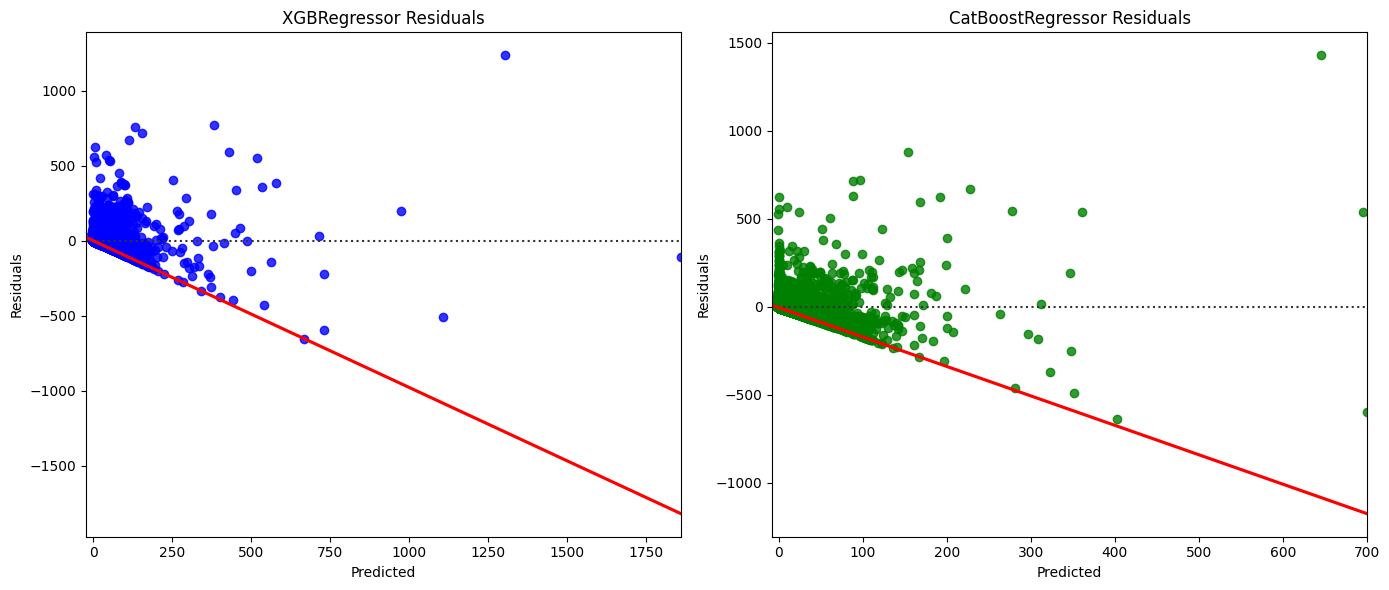

In [97]:
# Residual plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.residplot(x=xgb_reg_predictions, y=y_reg - xgb_reg_predictions, lowess=True, color='blue', line_kws={'color': 'red'})
plt.title('XGBRegressor Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
sns.residplot(x=cat_reg_predictions, y=y_reg - cat_reg_predictions, lowess=True, color='green', line_kws={'color': 'red'})
plt.title('CatBoostRegressor Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

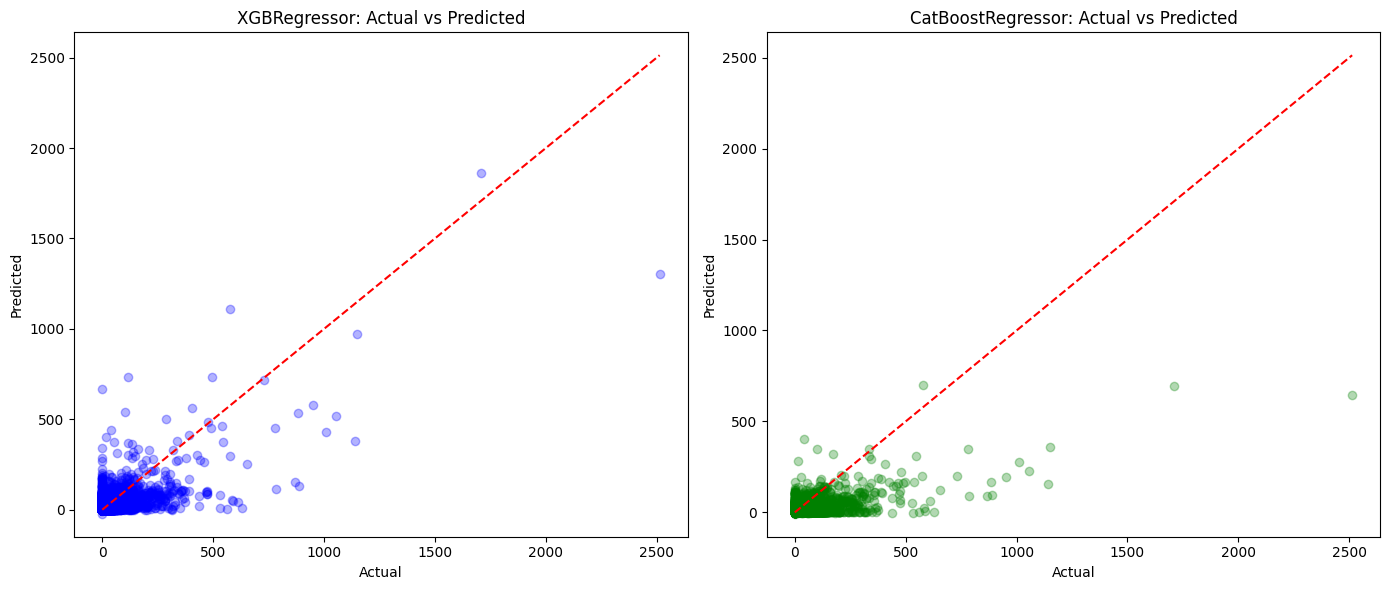

In [98]:
# Actual vs Predicted plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_reg, xgb_reg_predictions, alpha=0.3, color='blue')
plt.plot([y_reg.min(), y_reg.max()], [y_reg.min(), y_reg.max()], 'r--')
plt.title('XGBRegressor: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.subplot(1, 2, 2)
plt.scatter(y_reg, cat_reg_predictions, alpha=0.3, color='green')
plt.plot([y_reg.min(), y_reg.max()], [y_reg.min(), y_reg.max()], 'r--')
plt.title('CatBoostRegressor: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

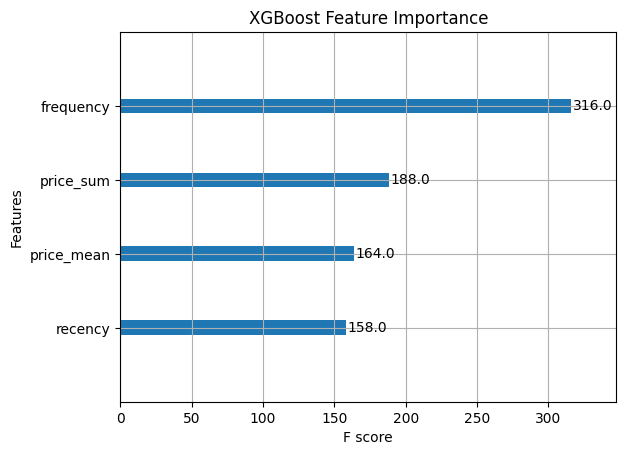

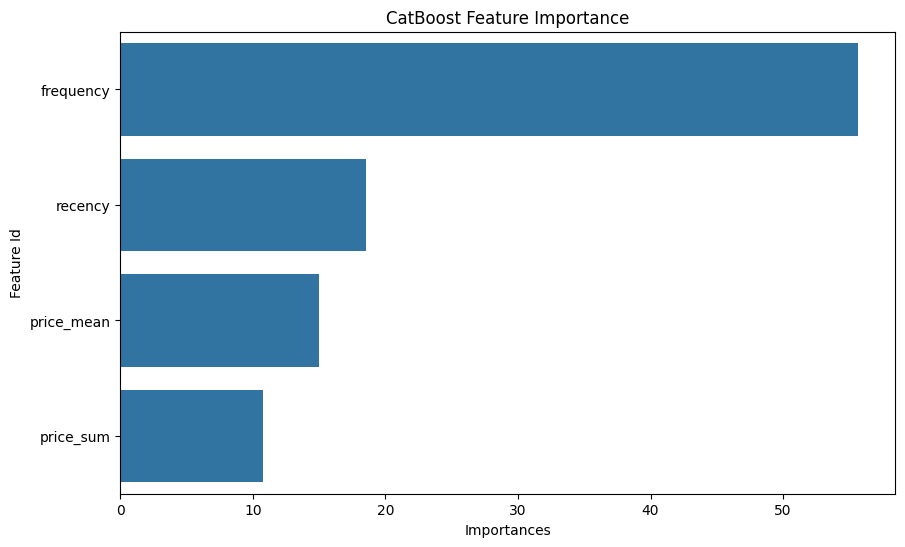

In [99]:
# Plot feature importance for XGBoost
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_reg_model, importance_type='weight')
plt.title('XGBoost Feature Importance')
plt.show()

# Plot feature importance for CatBoost
plt.figure(figsize=(10, 6))
cat_importance = best_cat_reg_model.get_feature_importance(prettified=True)
sns.barplot(x='Importances', y='Feature Id', data=cat_importance)
plt.title('CatBoost Feature Importance')
plt.show()

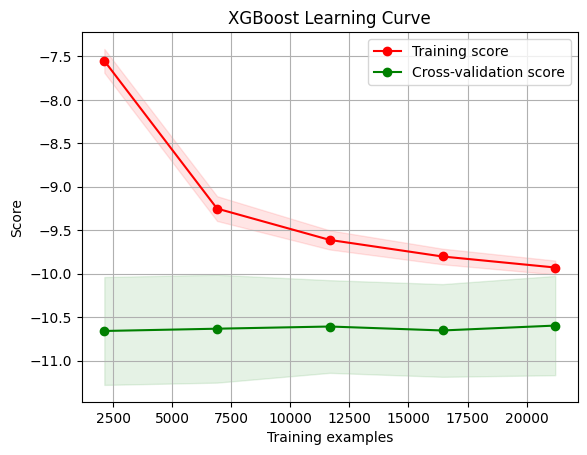

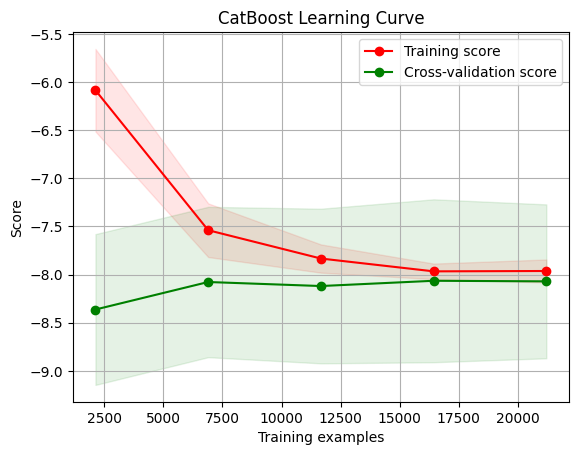

In [100]:
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_absolute_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
plot_learning_curve(best_xgb_reg_model, 'XGBoost Learning Curve', X, y_reg, cv=cv, n_jobs=n_jobs)
plot_learning_curve(best_cat_reg_model, 'CatBoost Learning Curve', X, y_reg, cv=cv, n_jobs=n_jobs)
plt.show()

XGBRegressor:
* MAE: 10.5976
* MSE: 1024.4278
* RMSE: 32.0067
* R²: 0.4625

CatBoostRegressor:
* MAE: 8.0699
* MSE: 1288.0488
* RMSE: 35.8894
* R²: 0.3242

Comparison:
1. Mean Absolute Error (MAE):
    * CatBoostRegressor has a lower MAE (8.0699) compared to XGBRegressor (10.5976), indicating that CatBoost has, on average, smaller absolute errors.
1. Mean Squared Error (MSE):
    * XGBRegressor has a lower MSE (1024.4278) compared to CatBoostRegressor (1288.0488), indicating that XGB has smaller squared errors overall.
1. Root Mean Squared Error (RMSE):
    *XGBRegressor has a lower RMSE (32.0067) compared to CatBoostRegressor (35.8894), indicating that XGB has fewer large errors compared to CatBoost.
1. R² (R-squared):
    * XGBRegressor has a higher R² (0.4625) compared to CatBoostRegressor (0.3242), indicating that XGB explains more of the variance in the target variable.

Conclusion:

MAE suggests that CatBoost has better average prediction accuracy.
MSE and RMSE suggest that XGBoost handles large errors better than CatBoost.
R² indicates that XGBoost explains more variance in the data than CatBoost.
Given these metrics, XGBRegressor seems to be the better-performing model overall, especially considering its ability to handle large errors and explain variance in the target variable. 

## 4.2 XGBoost Feature Tuning

Bayesian Optimization

In [107]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib
import numpy as np
import pandas as pd

In [104]:
# Data prep
features_df = pd.read_pickle('../artifacts/features_df.pkl')
# features_df = cudf.DataFrame.from_pandas(pandas_df)
y_reg = features_df['spend_90_total']
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]
# params
cv = 10
n_jobs = -1
random_seed=42

In [113]:
def xgb_evaluate(max_depth, gamma, subsample, colsample_bytree, learning_rate, alpha, lambda_, min_child_weight, scale_pos_weight):
    params = {
        'max_depth': int(max_depth),
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'learning_rate': learning_rate,
        'n_estimators': 100,
        'min_child_weight': min_child_weight,
        'alpha': alpha,
        'lambda': lambda_,
        'scale_pos_weight': scale_pos_weight,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
    }
    xgb_model = XGBRegressor(**params)
    cv_result = cross_val_score(xgb_model, X, y_reg, cv=10, scoring='neg_mean_absolute_error')
    return np.mean(cv_result)

# Set the parameter bounds
param_bounds = {
    'max_depth': (3, 10),
    'gamma': (0, 0.5),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0),
    'learning_rate': (0.01, 0.3),
    'alpha': (0, 1),
    'lambda_': (1, 3),
    'min_child_weight': (1, 10),
    'scale_pos_weight': (1, 3)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=param_bounds, random_state=42)

# Optimize
optimizer.maximize(init_points=10, n_iter=50)

# Get the best parameters
best_params_bayes = optimizer.max['params']
best_params_bayes['max_depth'] = int(best_params_bayes['max_depth'])  # convert max_depth to int
print(f"Best parameters found by Bayesian Optimization: {best_params_bayes}")

# Fit the model with the best parameters
best_xgb_model_bayes = XGBRegressor(**best_params_bayes, objective='reg:squarederror', n_estimators=100)
best_xgb_model_bayes.fit(X, y_reg)

# Save the best model
joblib.dump(best_xgb_model_bayes, '../models/best_xgb_reg_model_bayes_tuned.pkl')

# Generate predictions using cross-validation
xgb_reg_predictions_bayes_tuned = cross_val_predict(best_xgb_model_bayes, X, y_reg, cv=10)

# Save the predictions
joblib.dump(xgb_reg_predictions_bayes_tuned, '../artifacts/xgb_reg_predictions_bayes_tuned.pkl')


|   iter    |  target   |   alpha   | colsam... |   gamma   |  lambda_  | learni... | max_depth | min_ch... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | -10.73    | 0.3745    | 0.9803    | 0.366     | 2.197     | 0.05525   | 4.092     | 1.523     | 2.732     | 0.8404    |
| 2         | -10.72    | 0.7081    | 0.6082    | 0.485     | 2.665     | 0.07158   | 4.273     | 2.651     | 1.608     | 0.8099    |
| 3         | -10.83    | 0.4319    | 0.7165    | 0.3059    | 1.279     | 0.09472   | 5.565     | 5.105     | 2.57      | 0.6799    |
| 4         | -10.81    | 0.5142    | 0.837     | 0.02323   | 2.215     | 0.05945   | 3.455     | 9.54      | 2.931     | 0.9234    |
| 5         | -10.81    | 0.3046    | 0.6391    | 0.3421    | 1.88      | 0.04539   | 6.466     | 1.309     | 2.819     | 0.7035    |
| 6         | -10.99    | 0.6625    | 0.7247    | 0.26      | 

/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:54:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1717021965948/work/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:54:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1717021965948/work/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:54:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1717021965948/work/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:54:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1717021965948/work/src/learner.cc

['../artifacts/xgb_reg_predictions_bayes_tuned.pkl']

In [112]:
# Evaluation function
def evaluate_model(predictions, true_values):
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predictions)
    return mae, mse, rmse, r2

# Evaluate the tuned model
xgb_mae_bayes_tuned, xgb_mse_bayes_tuned, xgb_rmse_bayes_tuned, xgb_r2_bayes_tuned = evaluate_model(xgb_reg_predictions_bayes_tuned, y_reg)

print("Bayesian Tuned XGBRegressor:")
print(f"MAE: {xgb_mae_bayes_tuned:.4f}, MSE: {xgb_mse_bayes_tuned:.4f}, RMSE: {xgb_rmse_bayes_tuned:.4f}, R²: {xgb_r2_bayes_tuned:.4f}")

Bayesian Tuned XGBRegressor:
MAE: 10.6574, MSE: 1047.0541, RMSE: 32.3582, R²: 0.4506


### RandomizedSearchCV for thorough hyperparameter tuning

In [115]:
from sklearn.model_selection import RandomizedSearchCV
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 8],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'alpha': [0, 0.1, 0.5, 1],
    'lambda': [1, 1.5, 2, 3],
    'scale_pos_weight': [1, 1.5, 2, 3]
}

# Initialize the XGBRegressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=100, 
                                   scoring='neg_mean_absolute_error', cv=10, verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X, y_reg)

# Get the best model
best_xgb_model_random = random_search.best_estimator_

# Save the best model
joblib.dump(best_xgb_model_random, '../models/best_xgb_reg_model_random_tuned.pkl')

# Generate predictions using cross-validation
xgb_reg_predictions_random_tuned = cross_val_predict(best_xgb_model_random, X, y_reg, cv=10)

# Save the predictions
joblib.dump(xgb_reg_predictions_random_tuned, '../artifacts/xgb_reg_predictions_random_tuned.pkl')


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


['../artifacts/xgb_reg_predictions_random_tuned.pkl']

In [116]:
# Evaluate the tuned model
xgb_mae_random_tuned, xgb_mse_random_tuned, xgb_rmse_random_tuned, xgb_r2_random_tuned = evaluate_model(xgb_reg_predictions_random_tuned, y_reg)

print("Randomized Search Tuned XGBRegressor:")
print(f"MAE: {xgb_mae_random_tuned:.4f}, MSE: {xgb_mse_random_tuned:.4f}, RMSE: {xgb_rmse_random_tuned:.4f}, R²: {xgb_r2_random_tuned:.4f}")

Randomized Search Tuned XGBRegressor:
MAE: 10.6532, MSE: 1078.7137, RMSE: 32.8438, R²: 0.4340


Neither of the two models out perform the initial XGBoost model.

## 4.3 Ensemble

In [130]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import joblib

In [131]:
# Data prep
features_df = pd.read_pickle('../artifacts/features_df.pkl')
# features_df = cudf.DataFrame.from_pandas(pandas_df)
y_reg = features_df['spend_90_total']
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]

In [132]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Initialize base models with hyperparameter tuning
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
catboost_model = CatBoostRegressor(loss_function='MAE', random_seed=42, verbose=0)

# Define hyperparameters for grid search
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

catboost_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 5, 7],
    'iterations': [100, 200, 300]
}

# Perform grid search for each model
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
catboost_grid_search = GridSearchCV(estimator=catboost_model, param_grid=catboost_param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

# Fit grid search
xgb_grid_search.fit(X_train, y_train)
catboost_grid_search.fit(X_train, y_train)

# Get best models
best_xgb_model = xgb_grid_search.best_estimator_
best_catboost_model = catboost_grid_search.best_estimator_

# Initialize stacking model with a ridge regression meta-model
stacking_model = StackingRegressor(
    estimators=[
        ('xgb', best_xgb_model),
        ('catboost', best_catboost_model)
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5
)

# Fit the stacking model
stacking_model.fit(X_train, y_train)

# Save the stacking model
joblib.dump(stacking_model, '../models/stacking_model_tuned.pkl')

# Predict on the test set
y_pred_test = stacking_model.predict(X_test)

In [133]:
# Evaluate model
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

test_mae, test_mse, test_rmse, test_r2 = evaluate_model(y_test, y_pred_test)

print("Tuned Stacking Model Test Metrics:")
print(f"MAE: {test_mae:.4f}, MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

Tuned Stacking Model Test Metrics:
MAE: 10.9942, MSE: 1088.4156, RMSE: 32.9911, R²: 0.5656


In [134]:
# Predict and evaluate on the training set (optional, to check for overfitting)
y_pred_train = stacking_model.predict(X_train)
train_mae, train_mse, train_rmse, train_r2 = evaluate_model(y_train, y_pred_train)

print("Tuned Stacking Model Train Metrics:")
print(f"MAE: {train_mae:.4f}, MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")

Tuned Stacking Model Train Metrics:
MAE: 10.4301, MSE: 780.3653, RMSE: 27.9350, R²: 0.5556


#### Ensemble 2

In [138]:
best_xgb_reg_model = joblib.load('../models/best_xgb_reg_model.pkl')
stacking_model = joblib.load('../models/stacking_model_tuned.pkl')

In [139]:
# Combining predictions from both models
xgb_predictions = best_xgb_reg_model.predict(X_test)
stacking_predictions = stacking_model.predict(X_test)

# Weighted average of predictions
combined_predictions = (xgb_predictions + stacking_predictions) / 2

# Evaluate combined model
combined_mae, combined_mse, combined_rmse, combined_r2 = evaluate_model(y_test, combined_predictions)

print("Combined Model Test Metrics:")
print(f"MAE: {combined_mae:.4f}, MSE: {combined_mse:.4f}, RMSE: {combined_rmse:.4f}, R²: {combined_r2:.4f}")

Combined Model Test Metrics:
MAE: 10.4917, MSE: 808.8655, RMSE: 28.4406, R²: 0.6772


## 4.4 Final Regression Model

In [185]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Data preparation
features_df = pd.read_pickle('../artifacts/features_df.pkl')
y_reg = features_df['spend_90_total']
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]

# Load the best models
best_xgb_reg_model = joblib.load('../models/best_xgb_reg_model.pkl')
stacking_model = joblib.load('../models/stacking_model.pkl')

# Combine predictions from both models
xgb_predictions = best_xgb_reg_model.predict(X)
stacking_predictions = stacking_model.predict(X)
combined_predictions = (xgb_predictions + stacking_predictions) / 2

# Save combined predictions to a separate file
combined_predictions_df = pd.DataFrame({'combined_predictions': combined_predictions})
combined_predictions_df.to_pickle('../artifacts/combined_reg_predictions_final.pkl')

# Evaluate combined model
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

combined_mae, combined_mse, combined_rmse, combined_r2 = evaluate_model(y_reg, combined_predictions)

print("Combined Model Metrics on All Data:")
print(f"MAE: {combined_mae:.4f}, MSE: {combined_mse:.4f}, RMSE: {combined_rmse:.4f}, R²: {combined_r2:.4f}")


Combined Model Metrics on All Data:
MAE: 9.9434, MSE: 695.0559, RMSE: 26.3639, R²: 0.6353


Given the metrics, the Combined Model on all data demonstrates superior performance in terms of prediction accuracy (MAE, MSE, RMSE) compared to both the previous ensemble models on the test set and the original XGBoost model. Despite having a slightly lower R² than the previous best combined model on the test set, its overall performance is robust and indicates that it is the best performing model.

## 4.4 Next 90-Day Spend Probability (Binary Classification)

In [ ]:
x_class = features_df[['recency','frequency','price_sum','price_mean']]

In [ ]:
y_prob = features_df['spend_90_flag']

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x_class, y_prob, test_size=0.2, random_state=42)

In [ ]:
# Define the XGBClassifier with hyperparameters
xgb_class_spec = XGBClassifier(
    objective='binary:logistic',
    # tree_method='hist', # gpu_hist depreciated
    # device='cuda', # now use this
    # gpu_id=0,
    random_state=42
)

xgb_class_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'alpha': [0, 0.1, 0.5, 1],  # L1 regularization term on weights
    'lambda': [1, 1.5, 2, 3]   # L2 regularization term on weights
}

# Grid search for XGBClassifier
xgb_class_grid_search = GridSearchCV(
    estimator=xgb_class_spec,
    param_grid=xgb_class_param_grid,
    scoring='roc_auc',
    refit=True,
    cv=5,
    n_jobs=-1
)

In [ ]:
# Fit the model using the training data
xgb_class_grid_search.fit(X_train, y_train)

In [ ]:
# Define the CatBoostClassifier with hyperparameters
cat_class_spec = CatBoostClassifier(
    loss_function='Logloss',
    random_seed=42,
    verbose=0 
)

# Define the hyperparameter grid
cat_class_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 4, 5, 6],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Define the GridSearchCV object
cat_class_grid_search = GridSearchCV(
    estimator=cat_class_spec,
    param_grid=cat_class_param_grid,
    scoring='roc_auc',
    refit=True,
    cv=5,
    n_jobs=6
)


In [ ]:
# Fit the model using the training data
cat_class_grid_search.fit(X_train, y_train)

### Classification Interpretation

In [ ]:
from sklearn.metrics import roc_auc_score, mean_absolute_error

In [ ]:
# Evaluate XGBClassifier on test set
xgb_best_model = xgb_class_grid_search.best_estimator_
xgb_y_pred_proba = xgb_best_model.predict_proba(X_test)[:, 1]
xgb_roc_auc = roc_auc_score(y_test, xgb_y_pred_proba)
print("XGBClassifier Best ROC AUC: ", xgb_roc_auc)

# Evaluate CatBoostClassifier on test set
cat_class_best_model = cat_class_grid_search.best_estimator_
cat_y_pred_proba = cat_class_best_model.predict_proba(X_test)[:, 1]
cat_roc_auc = roc_auc_score(y_test, cat_y_pred_proba)
print("CatBoostClassifier Best ROC AUC: ", cat_roc_auc)

# Print best parameters
print("Best parameters for XGBClassifier: ", xgb_class_grid_search.best_params_)
print("Best parameters for CatBoostClassifier: ", cat_class_grid_search.best_params_)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

xgb_class_y_pred = xgb_best_model.predict(X_test)
cat_class_y_pred = cat_class_best_model.predict(X_test)

print("XGBClassifier Accuracy: ", accuracy_score(y_test, xgb_class_y_pred))
print("XGBClassifier Precision: ", precision_score(y_test, xgb_class_y_pred))
print("XGBClassifier Recall: ", recall_score(y_test, xgb_class_y_pred))
print("XGBClassifier F1 Score: ", f1_score(y_test, xgb_class_y_pred))
print('')
print("CatBoostClassifier Accuracy: ", accuracy_score(y_test, cat_class_y_pred))
print("CatBoostClassifier Precision: ", precision_score(y_test, cat_class_y_pred))
print("CatBoostClassifier Recall: ", recall_score(y_test, cat_class_y_pred))
print("CatBoostClassifier F1 Score: ", f1_score(y_test, cat_class_y_pred))

**Model Assesment**

* Accuracy: Both models perform similarly.
* Precision: Both models have similar precision, indicating a similar rate of false positives.
* Recall: CatBoostClassifier has a higher recall, meaning it is better at identifying true positives.
* F1 Score: CatBoostClassifier has a higher F1 score, indicating a better balance between precision and recall.

**Conclusion:** Overall, based on these metrics, CatBoostClassifier slightly outperforms XGBClassifier due to its better recall and F1 score.

## 4.5 FEATURE IMPORTANCE

### Regression

In [ ]:
# Extract feature importance from CatBoostRegressor
cat_reg_feature_importance = cat_reg_best_model.get_feature_importance()
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]

# Create a DataFrame for visualization
cat_reg_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': cat_reg_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(cat_reg_importance_df['Feature'], cat_reg_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - CatBoostRegressor')
plt.gca().invert_yaxis()
plt.show()

### Classification

In [ ]:
# Extract feature importance from CatBoostClassifier
cat_class_feature_importance = cat_class_best_model.get_feature_importance()
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]

# Create a DataFrame for visualization
cat_class_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': cat_class_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(cat_class_importance_df['Feature'], cat_class_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - CatBoostClassifier')
plt.gca().invert_yaxis()
plt.show()

# 5.0

### Combine Features

In [ ]:
# Load (unpickle) the predictions
cat_reg_y_pred = joblib.load('../artifacts/cat_reg_y_pred.pkl')
cat_class_y_pred_proba = joblib.load('../artifacts/cat_class_y_pred_proba.pkl')

In [ ]:
# Print shape to confirm
print(f"cat_reg_y_pred shape: {cat_reg_y_pred.shape}")

# Create DataFrame for the regression predictions
cat_reg_predictions_df = pd.DataFrame(cat_reg_y_pred, columns=['pred_spend'])

In [ ]:
# Print shape to confirm
print(f"cat_class_y_pred_proba shape: {cat_class_y_pred_proba.shape}")

# Create DataFrame for the predicted probabilities
cat_class_predictions_df = pd.DataFrame(cat_class_y_pred_proba, columns=['pred_prob'])

In [ ]:
# Ensure that the DataFrames have the same number of rows
assert len(cat_class_predictions_df) == len(cat_reg_predictions_df) == len(features_df), "Mismatch in number of rows"

# Combine the predicted probabilities, regression predictions, and original features
predictions_df = pd.concat(
    [
        cat_class_predictions_df.reset_index(drop=True),
        cat_reg_predictions_df.reset_index(drop=True),
        features_df.reset_index(drop=True)
    ], axis=1
)

In [ ]:
predictions_df

In [ ]:
predictions_df.to_pickle('../artifacts/predictions_df.pkl')

### Predictive Accuracy Analysis

In [ ]:
# Extract feature importance from CatBoostRegressor
cat_reg_feature_importance = cat_reg_best_model.get_feature_importance()
feature_names = X.columns if hasattr(X, 'columns') else [f'feature_{i}' for i in range(X.shape[1])]

# Create a DataFrame for visualization
cat_reg_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': cat_reg_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(cat_reg_importance_df['Feature'], cat_reg_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - CatBoostRegressor')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
cat_reg_importance_df.to_pickle('../artifacts/cat_reg_importance_df.pkl')

In [ ]:
# Extract feature importance from CatBoostClassifier
cat_class_feature_importance = cat_class_best_model.get_feature_importance()
feature_names = X.columns if hasattr(X, 'columns') else [f'feature_{i}' for i in range(X.shape[1])]

# Create a DataFrame for visualization
cat_class_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': cat_class_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(cat_class_importance_df['Feature'], cat_class_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - CatBoostClassifier')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
cat_class_importance_df.to_pickle('../artifacts/cat_class_importance_df.pkl')

In [ ]:
# True Positives
true_positives = predictions_df[
    (predictions_df['pred_spend'] > predictions_df['pred_spend'].median()) & 
    (predictions_df['spend_90_total'] > 0)
]

# False Positives
false_positives = predictions_df[
    (predictions_df['pred_spend'] > predictions_df['pred_spend'].median()) & 
    (predictions_df['spend_90_total'] == 0)
]

# True Negatives
true_negatives = predictions_df[
    (predictions_df['pred_spend'] <= predictions_df['pred_spend'].median()) & 
    (predictions_df['spend_90_total'] == 0)
]

# False Negatives
false_negatives = predictions_df[
    (predictions_df['pred_spend'] <= predictions_df['pred_spend'].median()) & 
    (predictions_df['spend_90_total'] > 0)
]


In [ ]:
# Define true labels and predicted probabilities
y_true = predictions_df['spend_90_flag']
y_pred_prob = predictions_df['pred_prob']

# Define predicted labels based on a threshold (e.g., 0.5)
threshold = 0.5
y_pred_label = (y_pred_prob >= threshold).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_label)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)

# Classification Report
class_report = classification_report(y_true, y_pred_label, target_names=['Not Spend', 'Spend'])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spend', 'Spend'], yticklabels=['Not Spend', 'Spend'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Print Classification Report
print("Classification Report:")
print(class_report)

### Model Assessment

**Classification**

* MAE of 8.016 suggests the average prediction error is moderate.
* RMSE of 36.802 indicates there are some large prediction errors, suggesting the presence of significant outliers or that the model is not handling some of the data points well.
* R-squared of 0.289 indicates that the model explains only a small portion of the variance in the target variable, suggesting it is not very effective in capturing the underlying patterns in the data.


# 6.0 BUSINESS VALUE

In [ ]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report

In [ ]:
predictions_df = pd.read_pickle('../artifacts/predictions_df.pkl')

### RFM Analysis

In [ ]:
# Recency segmentation
recent_customers = predictions_df[predictions_df['recency'] < 30]
average_customers = predictions_df[(predictions_df['recency'] >= 30) & (predictions_df['recency'] < 90)]
old_customers = predictions_df[predictions_df['recency'] >= 90]

# Frequency segmentation
frequent_customers = predictions_df[predictions_df['frequency'] > predictions_df['frequency'].median()]
infrequent_customers = predictions_df[predictions_df['frequency'] <= predictions_df['frequency'].median()]

# Monetary segmentation
high_value_customers = predictions_df[predictions_df['price_sum'] > predictions_df['price_sum'].median()]
low_value_customers = predictions_df[predictions_df['price_sum'] <= predictions_df['price_sum'].median()]

#### Visualize Recency Segmentation

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot Recency histogram
plt.subplot(1, 3, 1)
sns.histplot(predictions_df['recency'], bins=30, kde=True, color='blue')
plt.title('Recency Distribution')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Frequency')

# Plot Recency scatter plot
plt.subplot(1, 3, 2)
sns.scatterplot(data=predictions_df, x='recency', y='price_sum', hue='spend_90_flag', palette='coolwarm')
plt.title('Recency vs Spend')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Total Spend')

# Plot Recency box plot
plt.subplot(1, 3, 3)
sns.boxplot(x='spend_90_flag', y='recency', data=predictions_df, palette='coolwarm')
plt.title('Recency by Spend Flag')
plt.xlabel('Spend 90 Flag')
plt.ylabel('Days Since Last Purchase')

plt.tight_layout()
plt.show()


 #### Visualize Frequency Segmentation

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot Frequency histogram
plt.subplot(1, 3, 1)
sns.histplot(predictions_df['frequency'], bins=30, kde=True, color='green')
plt.title('Frequency Distribution')
plt.xlabel('Number of Purchases')
plt.ylabel('Frequency')

# Plot Frequency scatter plot
plt.subplot(1, 3, 2)
sns.scatterplot(data=predictions_df, x='frequency', y='price_sum', hue='spend_90_flag', palette='coolwarm')
plt.title('Frequency vs Spend')
plt.xlabel('Number of Purchases')
plt.ylabel('Total Spend')

# Plot Frequency box plot
plt.subplot(1, 3, 3)
sns.boxplot(x='spend_90_flag', y='frequency', data=predictions_df, palette='coolwarm')
plt.title('Frequency by Spend Flag')
plt.xlabel('Spend 90 Flag')
plt.ylabel('Number of Purchases')

plt.tight_layout()
plt.show()

#### Visualize Monetary Segmentation

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot Monetary histogram
plt.subplot(1, 3, 1)
sns.histplot(predictions_df['price_sum'], bins=30, kde=True, color='red')
plt.title('Monetary (Price Sum) Distribution')
plt.xlabel('Total Spend')
plt.ylabel('Frequency')

# Plot Monetary scatter plot
plt.subplot(1, 3, 2)
sns.scatterplot(data=predictions_df, x='price_sum', y='frequency', hue='spend_90_flag', palette='coolwarm')
plt.title('Spend vs Frequency')
plt.xlabel('Total Spend')
plt.ylabel('Number of Purchases')

# Plot Monetary box plot
plt.subplot(1, 3, 3)
sns.boxplot(x='spend_90_flag', y='price_sum', data=predictions_df, palette='coolwarm')
plt.title('Spend by Spend Flag')
plt.xlabel('Spend 90 Flag')
plt.ylabel('Total Spend')

plt.tight_layout()
plt.show()

### Customer Segmentation

In [ ]:
# High Probability & High Spend
high_prob_high_spend = predictions_df[
    (predictions_df['pred_prob'] > 0.7) & 
    (predictions_df['pred_spend'] > predictions_df['pred_spend'].median())
]

# Low Probability & Low Spend
low_prob_low_spend = predictions_df[
    (predictions_df['pred_prob'] <= 0.7) & 
    (predictions_df['pred_spend'] <= predictions_df['pred_spend'].median())
]

In [ ]:
# Define the threshold values for high and low segmentation
prob_threshold = 0.7
spend_threshold = predictions_df['pred_spend'].median()

# Define segments
predictions_df['Segment'] = 'Low Probability & Low Spend'
predictions_df.loc[(predictions_df['pred_prob'] > prob_threshold) & (predictions_df['pred_spend'] > spend_threshold), 'Segment'] = 'High Probability & High Spend'
predictions_df.loc[(predictions_df['pred_prob'] > prob_threshold) & (predictions_df['pred_spend'] <= spend_threshold), 'Segment'] = 'High Probability & Low Spend'
predictions_df.loc[(predictions_df['pred_prob'] <= prob_threshold) & (predictions_df['pred_spend'] > spend_threshold), 'Segment'] = 'Low Probability & High Spend'

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Scatter plot for customer segmentation
sns.scatterplot(data=predictions_df, x='pred_prob', y='pred_spend', hue='Segment', palette='coolwarm', s=100)
plt.title('Customer Segmentation based on Predicted Probability and Predicted Spend')
plt.xlabel('Predicted Probability')
plt.ylabel('Predicted Spend')
plt.legend(title='Segment')
plt.grid(True)
plt.show()

# Histograms for predicted probability and predicted spend
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Histogram for predicted probability
sns.histplot(predictions_df['pred_prob'], bins=30, kde=True, color='blue', ax=ax[0])
ax[0].set_title('Predicted Probability Distribution')
ax[0].set_xlabel('Predicted Probability')
ax[0].set_ylabel('Frequency')

# Histogram for predicted spend
sns.histplot(predictions_df['pred_spend'], bins=30, kde=True, color='green', ax=ax[1])
ax[1].set_title('Predicted Spend Distribution')
ax[1].set_xlabel('Predicted Spend')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Which customers have the highest spend probability in the next 90-days?

In [ ]:
predictions_df.sort_values('pred_prob', ascending=False).head(10)

### Which customers have recently purchases but are unlikely to buy?

* Incentivize actions to increase probability.
* Provide discounts, encourage referring a friend, nurture by letting them know what's coming.

In [ ]:
# customers that purchased in the last year but are unlikely to make another purchase
drop_out = predictions_df[
    (predictions_df['recency'] > -90) & 
    (predictions_df['pred_prob'] < 0.20)
].sort_values('pred_prob', ascending=False).head(10)

# Display the filtered DataFrame
drop_out

### Missed opportunities: spenders that could be unlocked

* Send bundle offers encourage volume purchases
* Focus on missed opportunities

In [ ]:
# Did the model predict any large spending that did not occur?
# Filtered by did not spend but had a high probability of spend and recency was within the last 90 days.
missed_opportunities = predictions_df[
    (predictions_df['spend_90_total'] == 0.0) & 
    (predictions_df['recency'] >= -90)
].sort_values('pred_prob', ascending=False).head(10)

# Display the filtered DataFrame
missed_opportunities

In [ ]:
# Show predictions that are larger than actual spend
# Filtered by pred spend is larger than actual, recency is last 90 days, and they actually made a purchase
under_spending = predictions_df[
    (predictions_df['pred_spend'] > predictions_df['spend_90_total']) & 
    (predictions_df['recency'] >= -90) & 
    (predictions_df['spend_90_flag'] == 1.0)
].sort_values('pred_spend', ascending=False).head(10)

# Display the filtered DataFrame
under_spending